In [10]:
import matplotlib.pyplot as plt
import os
try:
    %matplotlib inline
except NameError:  # in case it's a script. 
    pass

from menpo.shape import Tree
import numpy as np

In [11]:
from menpofit.dpm import DPM, DPMFitter, non_max_suppression_fast, clip_boxes, bb_to_lns

In [15]:
def get_components(model, pyra_pad):
    from scipy.sparse import csr_matrix
    # implementation of the modelcomponents to return the components
    components = []
    comp_m = model['components'][0][0][0] # *_m = * in matlab
    for c in range(len(comp_m)):    # 13 components
        cm = comp_m[c][0]
        def_ids = []
        filter_ids = []
        parents = []
        filter_index = []
        bias = 0
        anchors = []
        num_parts = len(cm)
        for k in range(num_parts):    # 68 parts
            def_id = cm[k]['defid'][0][0]
            def_ids.append(def_id)
            filter_id = cm[k]['filterid'][0][0]
            filter_ids.append(filter_id)
            parents.append(cm[k]['parent'][0][0] - 1)
            filter_index.append(model['filters'][0][0][0][filter_id - 1][1][0][0])  # -1 due to python numbering
            x = model['defs'][0][0][0][def_id - 1]  # -1 due to python numbering
            (ax, ay, ds) = np.copy(x['anchor'][0])
            if k == 0:
                bias = 1*x['w'][0][0]
            anchors.append((ay, ax))
        pairs = zip(parents, range(num_parts))
        tree_matrix = csr_matrix(([1] * (num_parts-1), (zip(*pairs[1:]))), shape=(num_parts, num_parts))
        tree = Tree(tree_matrix, root_vertex=0, skip_checks=True)
        component = dict()
        component['def_ids'] = def_ids
        component['filter_ids'] = filter_ids
        component['tree'] = tree
        component['filter_index'] = filter_index
        component['bias'] = bias
        component['anchors'] = anchors
        components.append(component)
    # for c in range(len(comp_m)):
    #     cm = comp_m[c][0]
    #     comp_parts = []
    #     for k in range(len(cm)):
    #         p = {}
    #         p['defid'] = cm[k]['defid'][0][0]
    #         p['filterid'] = cm[k]['filterid'][0][0]
    #         p['parent'] = cm[k]['parent'][0][0] - 1
    #         p['filterI'] = model['filters'][0][0][0][p['filterid'] - 1][1][0][0]  # -1 due to python numbering
    #
    #         x = model['defs'][0][0][0][p['defid'] - 1]  # -1 due to python numbering
    #         p['w'] = 1 * x['w'][0]  # http://stackoverflow.com/a/6435446
    #         (ax, ay, ds) = np.copy(x['anchor'][0])
    #         p['starty'] = ay
    #         p['startx'] = ax
    #
    #         comp_parts.append(dict(p))
    #     components.append(list(comp_parts)) # in outer loop
    return components


def copy_to_new_array(arr):
    # copies each value of an original array to a new one in the same shape.
    # Due to matlab having column-major.
    sh = arr.shape
    new = np.empty(sh, order='C')
    for c in range(sh[0]):
        for i in range(sh[1]):
            for j in range(sh[2]):
                new[c, i, j] = np.copy(arr[c, i, j])
    return new


def get_filters(model):
    ff = model['filters'][0][0][0]
    filters = []
    for i in range(len(ff)):
        tt = np.rollaxis(ff[i]['w'], 2)  # rollaxis, as long as matlab model is loaded (channels in front).
        tt = tt[:-1, :, :]  # hack as long as matlab hog is loaded (32 vs 31 feats in python).
        tt2 = copy_to_new_array(tt)
        filters.append(tt2)
    return filters

def get_defs(model):
    model_defs_all = model['defs'][0][0][0]
    defs_all = []
    for i in range(len(model_defs_all)):
        defs = model_defs_all[i]['w'][0]
        defs_all.append(defs)
    return defs_all


def debugging():
    # temp debugging
    # define the tree
    from os.path import isdir
    import scipy.io
    from scipy.sparse import csr_matrix
    import menpo.io as mio
    m68 = csr_matrix(([1] * 67, (
        [0,  0,  0,  0,  1,  3,  5,  6,  7,  8,  8,  9,  9, 10, 12, 13, 14,
         15, 16, 17, 18, 20, 20, 21, 23, 24, 25, 26, 27, 28, 29, 31, 31, 31,
         32, 32, 33, 33, 38, 38, 39, 39, 40, 43, 44, 45, 46, 46, 47, 48, 50,
         51, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66],
        [1,  3,  5, 31,  2,  4,  6,  7,  8,  9, 20, 10, 12, 11, 13, 14, 15,
         16, 17, 18, 19, 21, 23, 22, 24, 25, 26, 27, 28, 29, 30, 32, 37, 38,
         33, 36, 34, 35, 39, 42, 40, 41, 43, 44, 45, 46, 47, 50, 48, 49, 51,
         52, 60, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67])), shape=(68, 68))
    tree = Tree(m68, root_vertex=0, skip_checks=True)   # ## check

    # import the mat file (with the model).
    pm = '/vol/atlas/homes/grigoris/external/dpm_ramanan/face-release1.0-basic/'
    assert(isdir(pm))
    file1 = pm + 'face_p146_small.mat'
    mat = scipy.io.loadmat(file1)

    model = mat['model']
    filters_all = get_filters(model)
    defs_all = get_defs(model)
    _ms = model['maxsize'][0][0][0]
    sbin = model['sbin'][0][0][0][0]
    thresh = min(-0.55, model['thresh'][0][0][0][0])
    #thresh = min(-50, model['thresh'][0][0][0][0])
    pyra_pad = (max(_ms[1] - 2, 0), max(_ms[0] - 2, 0))  # (padx, pady)
    components = get_components(model, pyra_pad)


    # random component, chosen for debugging
    # parts = components[6]
    # def_coef = []  # deformation coefficients
    # filters = []  # filters for the component chosen
    # anchor = []
    # bias = parts[tree.root_vertex]['w'][0]
    # for c, pk in enumerate(parts):
    #     filters.append(filters_all[pk['filterid'] - 1])
    #     if c == 0:  # root is on 0 by default in Ramanan
    #         (w1, w2, w3, w4) = (0., 0., 0., 0.)
    #     else:
    #         (w1, w2, w3, w4) = -pk['w']
    #     def_coef.append((w1, w2, w3, w4))
    #     anchor.append((pk['starty'], pk['startx']))
    #
    # print filters

    im = mio.import_builtin_asset.takeo_ppm()

    dpm = DPM(filters_all, defs_all, components)    # todo: this actually should have been learnt from the images
    boxes = DPMFitter(dpm).fit(im, thresh)
    boxes.sort(key=lambda item: item['s'], reverse=True)
    boxes = [boxes[2]]
    cc, pick = non_max_suppression_fast(clip_boxes(boxes), 0.3)
    lns = bb_to_lns(boxes, pick)
    return lns, im

In [16]:
lns1, im = debugging()

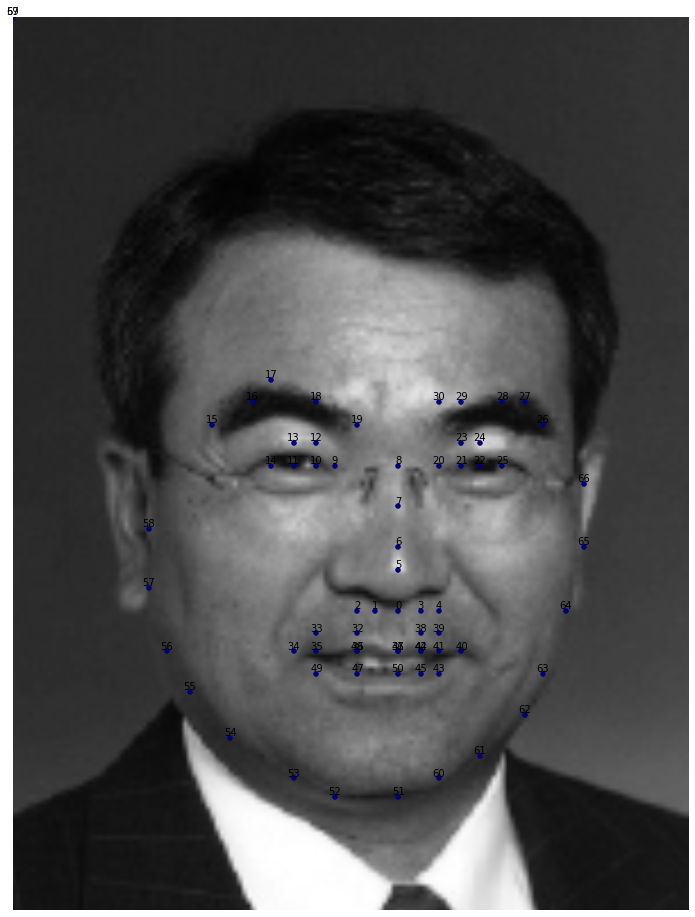

In [17]:
from menpo.shape import PointCloud
im.landmarks['PTS'] = PointCloud(lns1[0])
im2 = im.crop_to_landmarks_proportion(0.2)
im2.view_landmarks(render_numbering=True, figure_size=(22, 16))